# sktime tutorial

We present [sktime](https://github.com/alan-turing-institute/sktime), a new scikit-learn compatible Python toolbox for machine learning with time series. 

The tutorial consists of two parts: 
1. Representing time series data

2. Time series classification

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Representing time series data

### How does sktime represent time series?
Time series data comes in many different forms and there are many different ways to represent them. There is currently no consensus on how to best represent time series data for the purpose of modelling and evaluating machine learning workflows. 

For the purpose of machine learning with time series, the common formats of representing time series have drawbacks. Following scikit-learn and standard mathematical notation, we store time series in tables with rows representing i.i.d. instances and columns representing different variables (i.e. different kinds of measurements), but crucially, we extend the standard representation by allowing variables to not only represent primitive values (e.g. integers, floats and strings) but also entire series. 

To do this, sktime uses [pandas](https://pandas.pydata.org) data containers, but in a slightly different way than the intended usage. Pandas data containers are designed to store primitive data types in their cells, e.g. integers, floats or strings. Technically, however, pandas cells can store arbitrary types. Inspired by [xpandas](https://github.com/alan-turing-institute/xpandas), we exploit this possibility to store not just primitive types, but entire series in cells. This gives us a very flexible representation of time series data. It enables us to represent time heterogenous series, i.e. series which do not share a common time index across instances and/or variables. At the same time, we can still make use of most of pandas' functionality and familiar interface. Nevertheless, there are a number of disadvantages, which we try to address in future work. 

Much of the disucssion around the data representation is still ongoing. 

### Additional resources
* For more details on representing time series data, see our [wiki entry](https://github.com/alan-turing-institute/sktime/wiki/Data-representation-in-sktime), our [paper](https://arxiv.org/pdf/1909.07872.pdf), and this [document](https://github.com/MaxBenChrist/awesome_time_series_in_python/blob/master/standardize_time_series_formats.md) by one of the [tsfresh](https://github.com/blue-yonder/tsfresh) developers
* For a list of available alternative data containers we considered, please see our [wiki entry on related software](https://github.com/alan-turing-institute/sktime/wiki/Related-software#time-series-data-containers)
* For the ongoing discussion about data representation in sktime, see [issue #15](https://github.com/alan-turing-institute/sktime/issues/15) on GitHub
* For more code examples for loading data into the format assumed by sktime, see this [example notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/loading_data.ipynb)

### Example dataset
Here we load an example classification dataset from the literature, called GunPoint, and inspect the returned pandas data container. 

> The GunPoint problem contains univariate tracking data of actor's wrists as they either take a prop gun from a holster, point it, and return it to the holster, or they simply mime the action without the prop. The classification problem is to detect whether a motion trace is a case of _gun_ or _no gun_. The most discriminatory part of the time series shown above offers an interpretable result into how classification decisions can be made; the highlighted red section of the series above is where an actor returns the gun to the holster. As explained in [1], this is discriminatory because if the gun prop is present then the actor's hand stops suddenly, but if the prop is not present, the actor's hand will not stop abruptly and will subtly continue past their waist due to inertia. 

![shapelet gun point](img/shapelets_gun_point.PNG)

In [9]:
from sktime.datasets import load_gunpoint

In [10]:
X_train, y_train = load_gunpoint("TRAIN", return_X_y=True)

In [11]:
# nested pandas dataframe, with entire series in cells 
X_train.head()

,dim_0
0,0 -0.64789 1 -0.64199 2 -0.63819 3...
1,0 -0.64443 1 -0.64540 2 -0.64706 3...
2,0 -0.77835 1 -0.77828 2 -0.77715 3...
3,0 -0.75006 1 -0.74810 2 -0.74616 3...
4,0 -0.59954 1 -0.59742 2 -0.59927 3...


In [12]:
X_train.shape

(50, 1)

In [13]:
# in each cell, there is an entire series
X_train.iloc[0, 0].head()

0   -0.64789
1   -0.64199
2   -0.63819
3   -0.63826
4   -0.63835
dtype: float64

In [14]:
X_train.iloc[0, 0].shape

(150,)

### Exercise: Accessing and plotting time series in data container
Play around with the data container. For example, how would you plot the time series in the first row?

### Feedback
* Is the documentation clear on how we represent time series data in sktime? What could we improve?
* How we could improve the design of data container? 

## 2. Time series classification

Now we try to train a classifier on the training data and then evaluate it on the held out test data.

In [15]:
# load training and test set
X_train, y_train = load_gunpoint("TRAIN", return_X_y=True)
X_test, y_test = load_gunpoint("TEST", return_X_y=True)

In [16]:
# binary target variable, almost balanced
np.unique(y_train, return_counts=True)

(array(['1', '2'], dtype='<U1'), array([24, 26]))

### K-nearest-neighbours classifier for time series
One of the most popular time series classifiers is the k-nearest-neighbours algorithm based on a [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) (or short: dtw) distance measure. 

In [34]:
from sktime.classifiers.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(metric="dtw")
knn.fit(X_train, y_train) # ignore the FutureWarning from sklearn
y_pred = knn.predict(X_test)

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9066666666666666

### Time series forest classifier
Another popular classifier is time series forest, a variation of a random forest adapted to the time series setting, based on randomised time series segmentation and feature extraction. 

In [37]:
from sktime.classifiers.compose import TimeSeriesForestClassifier

In [36]:
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9666666666666667

We can also plot the feature importance of the three extracted features over time: 

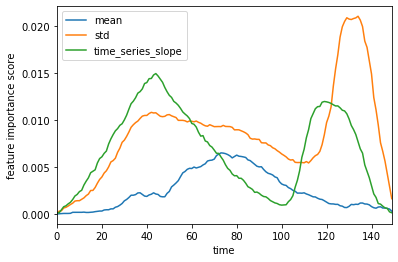

In [38]:
from sktime.contrib.interval_based.tsf_feature_importance_graph import feature_importances

# compute feature importance graph 
fi = feature_importances(tsf)  # experimental function, assumes specific structure of passed time series forest classifier
ax = fi.plot()
ax.set(xlabel="time", ylabel="feature importance score");

Implementing the feature importance functionality as a method of the time series forest classifier itself, is an open issues and a good first issue if you're interested in contributing to sktime. Check out the [good first issues on GitHub](https://github.com/alan-turing-institute/sktime/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22).    

### Exercise: More classifiers
Try out some other classifers! For example:

In [16]:
from sktime.classifiers.shapelet_based import ShapeletTransformClassifier

### Exercise: Tuning
Try out grid-search cross-validation to tune some of the hyper-parameters of the classifiers. 

In [1]:
from sktime.model_selection import GridSearchCV

### Exercise: Reduction 
Use the `Tabulariser` transformer in a pipeline to reduce the time series classification task to the tabular classification tasks and solve it with any classifier from scikit-learn. 

In [39]:
from sktime.transformers.compose import Tabulariser
from sktime.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  # any other classifier should work too

### More resources
* For shapelet based classification, see this [notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/shapelet_transform.ipynb)
* For more code examples of univariate time series classification, see this [notebook]()
* In this tutorial, we focus on univariate time series classification. For multivariate time series classification, check out this [notebook]((https://github.com/alan-turing-institute/sktime/blob/master/examples/multivariate_time_series_classification.ipynb))

### Feedback:
* What was the most difficult part to understand about the time series classification API? 
* How can we improve the documentation? 
* What additional features would you like to see?

## References
[1] Ye, Lexiang, and Eamonn Keogh. "Time series shapelets: a novel technique that allows accurate, interpretable and fast classification." Data mining and knowledge discovery 22, no. 1-2 (2011): 149-182.